In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy import stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


seed = 42

/kaggle/input/asdfghj/Screenshot 2020-06-22 at 16.09.48.png
/kaggle/input/jhgfds/train.csv
/kaggle/input/jhgfds/sample_submit.csv
/kaggle/input/jhgfds/test.csv


Thanks to organizers for this really cool competition and very unusual for data science. Especially the second part of competition was really nice and I learned something new from linear programming trying to make optimization as efficient as possible taking into account the bias from predicted target.

Prohack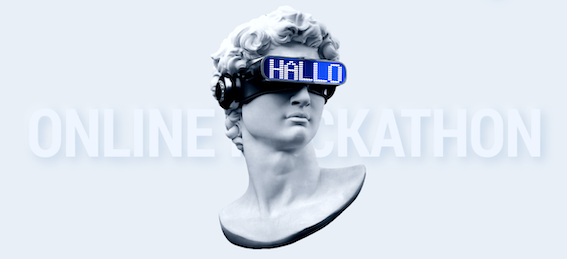

SciPy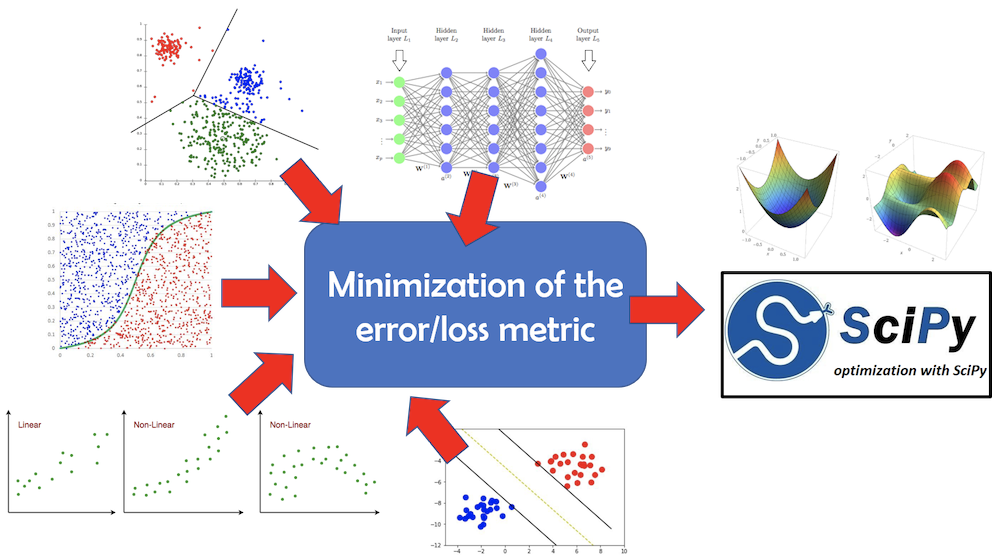

In [5]:
train = pd.read_csv('/kaggle/input/jhgfds/train.csv')
test = pd.read_csv('/kaggle/input/jhgfds/test.csv')
sample = pd.read_csv('/kaggle/input/jhgfds/sample_submit.csv')
df = pd.concat([train ,test], ignore_index = True)

In [ ]:
train.info()

In [ ]:
test.info()

In [6]:
for col in df.iloc[:,2:].columns.values:
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)

In [ ]:
not_matched_galaxies = ['Andromeda XVIII[60]', 'Andromeda XII', 'Andromeda XIX[60]', 'Hercules Dwarf', 'Triangulum Galaxy (M33)', 'Tucana Dwarf', 'Andromeda XXII[57]', 'NGC 5253', 'Andromeda XXIV']
train = train[~train['galaxy'].isin(not_matched_galaxies)]
data = data[~data['galaxy'].isin(not_matched_galaxies)]

In [7]:
cor = pd.DataFrame(train.corr()['y'].abs()).sort_values('y')

a = cor[cor['y'] > 0.1]

a

,y
Private galaxy capital flows (% of GGP),0.130659
"Outer Galaxies direct investment, net inflows (% of GGP)",0.130775
Youth unemployment rate (female to male ratio),0.147256
Adjusted net savings,0.164614
"Remittances, inflows (% of GGP)",0.182792
"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",0.210670
"Labour force participation rate (% ages 15 and older), male",0.214862
Natural resource depletion,0.223863
Renewable energy consumption (% of total final energy consumption),0.227842
"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",0.231993


In [8]:
# create some lags
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df['lag_' + str(i)] = df.groupby(['galaxy'])['y'].shift(i)

In [9]:
train_new = df[:train.shape[0]]
test_new = df[train.shape[0]:]

In [10]:
print('New train shape: {}'.format(train_new.shape))
print('New test shape: {}'.format(test_new.shape))

New train shape: (3865, 90)
New test shape: (890, 90)


In [11]:
le = LabelEncoder()
train_new['galaxy'] = le.fit_transform(train_new.galaxy)
test_new['galaxy'] = le.transform(test_new.galaxy)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
X = train_new.drop(['y'], axis = 1)
y = train_new.y
X_test = test_new.drop(['y'], axis = 1)

<h3> LGBM

In [14]:
import re
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [19]:
seed = 42

params_lgb = {
   
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'verbose': 1,
    "max_depth": 6,
    "num_leaves": 20,
    "seed": seed
    }

def RMSE_error(y, y_pr):
    return np.sqrt(mean_squared_error(y, y_pr))

scores = []
folds = KFold(n_splits = 10)

predictions = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
   
    print("Fold {}".format(fold_))


    trn_data = lgb.Dataset(X.iloc[trn_idx], label = y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label = y.iloc[val_idx])

    num_round = 1000000
    
    lgbm = lgb.train(params_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval = 1000, early_stopping_rounds = 100)
    predictions_val = lgbm.predict(X.iloc[val_idx], num_iteration = lgbm.best_iteration)
    
    score = RMSE_error(predictions_val, y.iloc[val_idx])
    scores.append(score)
    
    print("CV score: {:<8.5f}".format(RMSE_error(predictions_val, y.iloc[val_idx])))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = lgbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    predictions += lgbm.predict(X_test, num_iteration = lgbm.best_iteration) / folds.n_splits
    
print('CV mean: {:.6f}, CV std: {:.6f}'.format(np.mean(scores), np.std(scores)))

Fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's rmse: 0.024565	valid_1's rmse: 0.0412326
CV score: 0.04123 
Fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[826]	training's rmse: 0.000732018	valid_1's rmse: 0.00232781
CV score: 0.00233 
Fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's rmse: 0.00811509	valid_1's rmse: 0.00317123
CV score: 0.00317 
Fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	training's rmse: 0.00146962	valid_1's rmse: 0.00141545
CV score: 0.00142 
Fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	training's rmse: 0.0091615	valid_1's rmse: 0.00348815
CV score: 0.00349 
Fold 5
Training until validation scores don't improve for 100 rounds
Early stopping, b

Text(0.5, 1.0, 'Features importance (averaged/folds)')

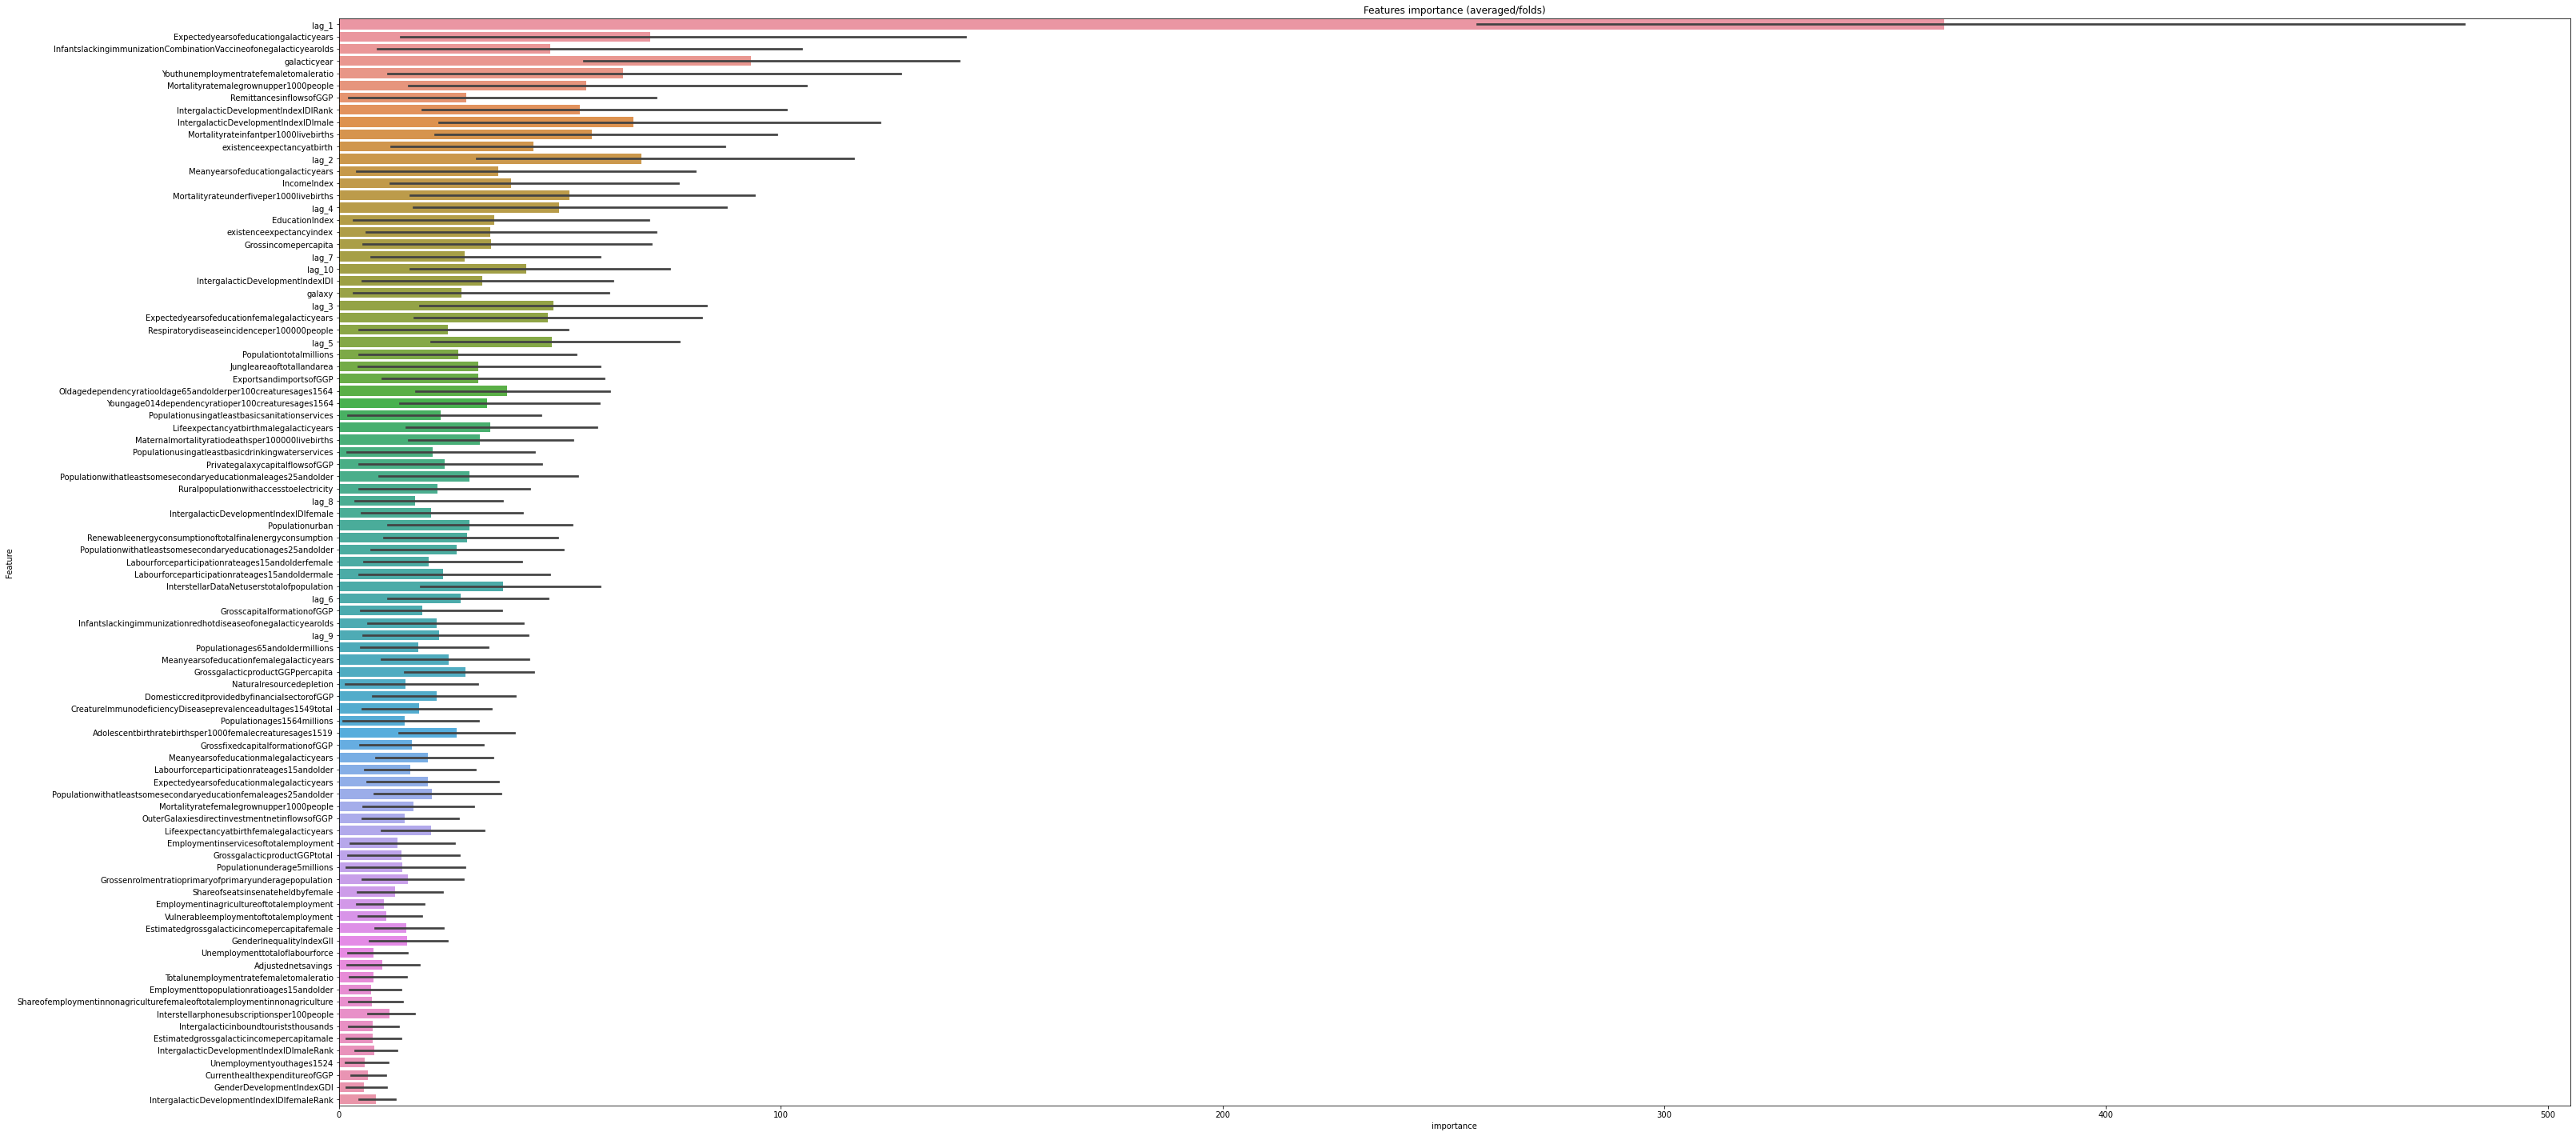

In [18]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by = "importance", ascending = False).index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize = (50, 25))
sns.barplot(x = "importance", y = "Feature", data = best_features.sort_values(by = "importance", ascending = False))
plt.title('Features importance (averaged/folds)')

In [67]:
important_cols = ['galactic year', 'galaxy', 'lag_1']
X = X[important_cols]
X_test = X_test[important_cols]
X['y'] = train.y
X['galaxy'] = X['galaxy'].astype('object')
target_mean = dict(X.groupby(['galaxy'])['y'].agg('mean'))
target_median = dict(X.groupby(['galaxy'])['y'].agg('median'))
target_max = dict(X.groupby(['galaxy'])['y'].agg('max'))
target_min = dict(X.groupby(['galaxy'])['y'].agg('min'))
target_change = dict(X.groupby(['galaxy'])['y'].agg('max') - X.groupby(['galaxy'])['y'].agg('min'))
target_percentile_1 = dict(X.groupby(['galaxy'])['y'].apply(lambda y: np.percentile(y, 95)))
target_percentile_2 = dict(X.groupby(['galaxy'])['y'].apply(lambda y: np.percentile(y, 99)))
target_std = dict(X.groupby(['galaxy'])['y'].agg('std'))
target_var = dict(X.groupby(['galaxy'])['y'].agg('var'))
target_end = dict(X.groupby(['galaxy'])['y'].agg('last'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [74]:
for i in [X, X_test]:
    i['mean'] = i['galaxy'].map(target_mean)
    i['median'] = i['galaxy'].map(target_median)
    i['max'] = i['galaxy'].map(target_max).values
    i['min'] = i['galaxy'].map(target_min).values
    i['percentile_1'] = i['galaxy'].map(target_percentile_1)
    i['percentile_2'] = i['galaxy'].map(target_percentile_2)
    i['std'] = i['galaxy'].map(target_std)
    i['var'] = i['galaxy'].map(target_var)
    i['end'] = i['galaxy'].map(target_end)
    i['change'] = i['galaxy'].map(target_change)
    
X = X.drop(['galaxy', 'lag_1'], axis = 1)
X_test = X_test.drop(['galaxy', 'lag_1'], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<h3> Find ensemble weights for 3 model (Catboost, lightgbm, xgboost)

In [80]:
# split dataset for train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [81]:
# catboost predictions
catboost_parameters = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'iterations' : 5000,
          'l2_leaf_reg' : 5,
          'random_seed' : seed,
          'depth' : 5,
          'early_stopping_rounds' : 100,
          'use_best_model' : True
         }
cb = CatBoostRegressor(**catboost_parameters)
cb.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_catboost = cb.predict(X_valid)

0:	learn: 0.0583521	test: 0.0526577	best: 0.0526577 (0)	total: 2.49ms	remaining: 12.5s
1:	learn: 0.0533109	test: 0.0478072	best: 0.0478072 (1)	total: 5.35ms	remaining: 13.4s
2:	learn: 0.0489014	test: 0.0432481	best: 0.0432481 (2)	total: 7.83ms	remaining: 13s
3:	learn: 0.0447362	test: 0.0393456	best: 0.0393456 (3)	total: 10.2ms	remaining: 12.8s
4:	learn: 0.0409953	test: 0.0359326	best: 0.0359326 (4)	total: 12.5ms	remaining: 12.5s
5:	learn: 0.0376171	test: 0.0324848	best: 0.0324848 (5)	total: 14.8ms	remaining: 12.3s
6:	learn: 0.0347478	test: 0.0298752	best: 0.0298752 (6)	total: 17.1ms	remaining: 12.2s
7:	learn: 0.0320064	test: 0.0272970	best: 0.0272970 (7)	total: 19.5ms	remaining: 12.2s
8:	learn: 0.0297560	test: 0.0251548	best: 0.0251548 (8)	total: 21.7ms	remaining: 12s
9:	learn: 0.0273848	test: 0.0228405	best: 0.0228405 (9)	total: 23.9ms	remaining: 11.9s
10:	learn: 0.0254656	test: 0.0209423	best: 0.0209423 (10)	total: 26.2ms	remaining: 11.9s
11:	learn: 0.0235393	test: 0.0189473	best: 0.

168:	learn: 0.0021801	test: 0.0032767	best: 0.0032767 (168)	total: 384ms	remaining: 11s
169:	learn: 0.0021730	test: 0.0032801	best: 0.0032767 (168)	total: 386ms	remaining: 11s
170:	learn: 0.0021665	test: 0.0032833	best: 0.0032767 (168)	total: 388ms	remaining: 11s
171:	learn: 0.0021551	test: 0.0032774	best: 0.0032767 (168)	total: 390ms	remaining: 11s
172:	learn: 0.0021489	test: 0.0032804	best: 0.0032767 (168)	total: 392ms	remaining: 11s
173:	learn: 0.0021431	test: 0.0032832	best: 0.0032767 (168)	total: 395ms	remaining: 10.9s
174:	learn: 0.0021321	test: 0.0032781	best: 0.0032767 (168)	total: 397ms	remaining: 10.9s
175:	learn: 0.0021226	test: 0.0032735	best: 0.0032735 (175)	total: 399ms	remaining: 10.9s
176:	learn: 0.0021146	test: 0.0032687	best: 0.0032687 (176)	total: 401ms	remaining: 10.9s
177:	learn: 0.0021010	test: 0.0032654	best: 0.0032654 (177)	total: 404ms	remaining: 10.9s
178:	learn: 0.0020916	test: 0.0032562	best: 0.0032562 (178)	total: 406ms	remaining: 10.9s
179:	learn: 0.002085

338:	learn: 0.0013492	test: 0.0028683	best: 0.0028674 (336)	total: 764ms	remaining: 10.5s
339:	learn: 0.0013476	test: 0.0028676	best: 0.0028674 (336)	total: 768ms	remaining: 10.5s
340:	learn: 0.0013463	test: 0.0028676	best: 0.0028674 (336)	total: 770ms	remaining: 10.5s
341:	learn: 0.0013440	test: 0.0028668	best: 0.0028668 (341)	total: 772ms	remaining: 10.5s
342:	learn: 0.0013415	test: 0.0028661	best: 0.0028661 (342)	total: 774ms	remaining: 10.5s
343:	learn: 0.0013404	test: 0.0028661	best: 0.0028661 (342)	total: 777ms	remaining: 10.5s
344:	learn: 0.0013381	test: 0.0028653	best: 0.0028653 (344)	total: 779ms	remaining: 10.5s
345:	learn: 0.0013347	test: 0.0028624	best: 0.0028624 (345)	total: 781ms	remaining: 10.5s
346:	learn: 0.0013323	test: 0.0028603	best: 0.0028603 (346)	total: 783ms	remaining: 10.5s
347:	learn: 0.0013291	test: 0.0028587	best: 0.0028587 (347)	total: 786ms	remaining: 10.5s
348:	learn: 0.0013280	test: 0.0028579	best: 0.0028579 (348)	total: 788ms	remaining: 10.5s
349:	learn

505:	learn: 0.0010391	test: 0.0027607	best: 0.0027546 (456)	total: 1.14s	remaining: 10.1s
506:	learn: 0.0010387	test: 0.0027647	best: 0.0027546 (456)	total: 1.15s	remaining: 10.2s
507:	learn: 0.0010376	test: 0.0027645	best: 0.0027546 (456)	total: 1.15s	remaining: 10.2s
508:	learn: 0.0010368	test: 0.0027679	best: 0.0027546 (456)	total: 1.15s	remaining: 10.1s
509:	learn: 0.0010354	test: 0.0027660	best: 0.0027546 (456)	total: 1.15s	remaining: 10.1s
510:	learn: 0.0010340	test: 0.0027666	best: 0.0027546 (456)	total: 1.15s	remaining: 10.1s
511:	learn: 0.0010335	test: 0.0027667	best: 0.0027546 (456)	total: 1.16s	remaining: 10.1s
512:	learn: 0.0010327	test: 0.0027702	best: 0.0027546 (456)	total: 1.16s	remaining: 10.1s
513:	learn: 0.0010320	test: 0.0027734	best: 0.0027546 (456)	total: 1.16s	remaining: 10.1s
514:	learn: 0.0010314	test: 0.0027766	best: 0.0027546 (456)	total: 1.16s	remaining: 10.1s
515:	learn: 0.0010306	test: 0.0027763	best: 0.0027546 (456)	total: 1.17s	remaining: 10.1s
516:	learn

In [82]:
# lgbm predictions
lgbm_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    "max_depth": 5,
    "num_leaves": 20,  
    "seed": seed,
    "early_stopping_rounds": 100,
    'num_round' : 1000000
    }
lgbm = LGBMRegressor(**lgbm_parameters)
lgbm.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_lightgbm = lgbm.predict(X_valid)

Found `num_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's rmse: 0.0465819
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.0375449
[3]	valid_0's rmse: 0.02998
[4]	valid_0's rmse: 0.0239996
[5]	valid_0's rmse: 0.0189312
[6]	valid_0's rmse: 0.0152638
[7]	valid_0's rmse: 0.0121869
[8]	valid_0's rmse: 0.00976464
[9]	valid_0's rmse: 0.00786761
[10]	valid_0's rmse: 0.00641292
[11]	valid_0's rmse: 0.00524313
[12]	valid_0's rmse: 0.00441983
[13]	valid_0's rmse: 0.0038503
[14]	valid_0's rmse: 0.0035319
[15]	valid_0's rmse: 0.00293544
[16]	valid_0's rmse: 0.00286132
[17]	valid_0's rmse: 0.00288749
[18]	valid_0's rmse: 0.00292941
[19]	valid_0's rmse: 0.00301779
[20]	valid_0's rmse: 0.00309546
[21]	valid_0's rmse: 0.0030759
[22]	valid_0's rmse: 0.00313395
[23]	valid_0's rmse: 0.00317753
[24]	valid_0's rmse: 0.00299747
[25]	valid_0's rmse: 0.00301606
[26]	valid_0's rmse: 0.00283552
[27]	valid_0's rmse: 0.00288998
[28]	valid_0's rmse: 0.00291795
[29]	valid_0's rmse: 0.00283382
[30]	valid_0's rmse: 0.0028559


[362]	valid_0's rmse: 0.00193715
[363]	valid_0's rmse: 0.00194335
[364]	valid_0's rmse: 0.00194404
[365]	valid_0's rmse: 0.00195108
[366]	valid_0's rmse: 0.00195166
[367]	valid_0's rmse: 0.00195127
[368]	valid_0's rmse: 0.00195806
[369]	valid_0's rmse: 0.00195784
[370]	valid_0's rmse: 0.00197658
[371]	valid_0's rmse: 0.00195782
[372]	valid_0's rmse: 0.0019284
[373]	valid_0's rmse: 0.0019288
[374]	valid_0's rmse: 0.00192613
[375]	valid_0's rmse: 0.00191317
[376]	valid_0's rmse: 0.00190683
[377]	valid_0's rmse: 0.00190168
[378]	valid_0's rmse: 0.00189102
[379]	valid_0's rmse: 0.00188498
[380]	valid_0's rmse: 0.00188493
[381]	valid_0's rmse: 0.00190846
[382]	valid_0's rmse: 0.00190421
[383]	valid_0's rmse: 0.00191171
[384]	valid_0's rmse: 0.00192064
[385]	valid_0's rmse: 0.0019296
[386]	valid_0's rmse: 0.00193394
[387]	valid_0's rmse: 0.00194565
[388]	valid_0's rmse: 0.00195159
[389]	valid_0's rmse: 0.00194293
[390]	valid_0's rmse: 0.00195024
[391]	valid_0's rmse: 0.00194019
[392]	valid_0

[622]	valid_0's rmse: 0.00195932
[623]	valid_0's rmse: 0.00194702
[624]	valid_0's rmse: 0.00193778
[625]	valid_0's rmse: 0.00193266
[626]	valid_0's rmse: 0.00193909
[627]	valid_0's rmse: 0.00192419
[628]	valid_0's rmse: 0.00191624
[629]	valid_0's rmse: 0.00191379
[630]	valid_0's rmse: 0.00190502
[631]	valid_0's rmse: 0.00190166
[632]	valid_0's rmse: 0.0019001
[633]	valid_0's rmse: 0.00189063
[634]	valid_0's rmse: 0.00188512
[635]	valid_0's rmse: 0.00188613
Early stopping, best iteration is:
[535]	valid_0's rmse: 0.00181279


In [83]:
# xgb predictions
xgboost_parameters = {
          'colsample_bytree' : 0.8,
          'gamma' : 0, 
          'booster' :  "gbtree",
          'eval_metric' : 'rmse',
          'eta' : 0.01,
          'max_depth' : 10,
          'min_child_weight' : 1.5,
          'n_estimators' : 5000,                                                                    
          'subsample' : 0.95,
          'seed' : seed
         }

xb = xgb.XGBRegressor(**xgboost_parameters)
xb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 100)
pred_xgboost = xb.predict(X_valid)

[0]	validation_0-rmse:0.41795
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.41376
[2]	validation_0-rmse:0.40962
[3]	validation_0-rmse:0.40552
[4]	validation_0-rmse:0.40146
[5]	validation_0-rmse:0.39744
[6]	validation_0-rmse:0.39348
[7]	validation_0-rmse:0.38954
[8]	validation_0-rmse:0.38564
[9]	validation_0-rmse:0.38178
[10]	validation_0-rmse:0.37796
[11]	validation_0-rmse:0.37417
[12]	validation_0-rmse:0.37043
[13]	validation_0-rmse:0.36672
[14]	validation_0-rmse:0.36305
[15]	validation_0-rmse:0.35942
[16]	validation_0-rmse:0.35583
[17]	validation_0-rmse:0.35226
[18]	validation_0-rmse:0.34874
[19]	validation_0-rmse:0.34525
[20]	validation_0-rmse:0.34179
[21]	validation_0-rmse:0.33838
[22]	validation_0-rmse:0.33499
[23]	validation_0-rmse:0.33165
[24]	validation_0-rmse:0.32833
[25]	validation_0-rmse:0.32504
[26]	validation_0-rmse:0.32178
[27]	validation_0-rmse:0.31857
[28]	validation_0-rmse:0.31538
[29]	validation_0-rmse:0.31222
[30]	validatio

[258]	validation_0-rmse:0.03146
[259]	validation_0-rmse:0.03115
[260]	validation_0-rmse:0.03084
[261]	validation_0-rmse:0.03053
[262]	validation_0-rmse:0.03023
[263]	validation_0-rmse:0.02993
[264]	validation_0-rmse:0.02963
[265]	validation_0-rmse:0.02934
[266]	validation_0-rmse:0.02905
[267]	validation_0-rmse:0.02876
[268]	validation_0-rmse:0.02847
[269]	validation_0-rmse:0.02819
[270]	validation_0-rmse:0.02791
[271]	validation_0-rmse:0.02763
[272]	validation_0-rmse:0.02736
[273]	validation_0-rmse:0.02708
[274]	validation_0-rmse:0.02681
[275]	validation_0-rmse:0.02655
[276]	validation_0-rmse:0.02628
[277]	validation_0-rmse:0.02602
[278]	validation_0-rmse:0.02576
[279]	validation_0-rmse:0.02551
[280]	validation_0-rmse:0.02525
[281]	validation_0-rmse:0.02500
[282]	validation_0-rmse:0.02475
[283]	validation_0-rmse:0.02451
[284]	validation_0-rmse:0.02427
[285]	validation_0-rmse:0.02402
[286]	validation_0-rmse:0.02379
[287]	validation_0-rmse:0.02355
[288]	validation_0-rmse:0.02331
[289]	va

[515]	validation_0-rmse:0.00277
[516]	validation_0-rmse:0.00275
[517]	validation_0-rmse:0.00273
[518]	validation_0-rmse:0.00271
[519]	validation_0-rmse:0.00269
[520]	validation_0-rmse:0.00267
[521]	validation_0-rmse:0.00265
[522]	validation_0-rmse:0.00263
[523]	validation_0-rmse:0.00261
[524]	validation_0-rmse:0.00259
[525]	validation_0-rmse:0.00257
[526]	validation_0-rmse:0.00255
[527]	validation_0-rmse:0.00253
[528]	validation_0-rmse:0.00251
[529]	validation_0-rmse:0.00249
[530]	validation_0-rmse:0.00247
[531]	validation_0-rmse:0.00246
[532]	validation_0-rmse:0.00244
[533]	validation_0-rmse:0.00242
[534]	validation_0-rmse:0.00240
[535]	validation_0-rmse:0.00239
[536]	validation_0-rmse:0.00237
[537]	validation_0-rmse:0.00235
[538]	validation_0-rmse:0.00234
[539]	validation_0-rmse:0.00232
[540]	validation_0-rmse:0.00230
[541]	validation_0-rmse:0.00229
[542]	validation_0-rmse:0.00227
[543]	validation_0-rmse:0.00226
[544]	validation_0-rmse:0.00224
[545]	validation_0-rmse:0.00223
[546]	va

[772]	validation_0-rmse:0.00125
[773]	validation_0-rmse:0.00125
[774]	validation_0-rmse:0.00125
[775]	validation_0-rmse:0.00125
[776]	validation_0-rmse:0.00125
[777]	validation_0-rmse:0.00125
[778]	validation_0-rmse:0.00125
[779]	validation_0-rmse:0.00125
[780]	validation_0-rmse:0.00125
[781]	validation_0-rmse:0.00124
[782]	validation_0-rmse:0.00124
[783]	validation_0-rmse:0.00124
[784]	validation_0-rmse:0.00124
[785]	validation_0-rmse:0.00124
[786]	validation_0-rmse:0.00124
[787]	validation_0-rmse:0.00124
[788]	validation_0-rmse:0.00124
[789]	validation_0-rmse:0.00124
[790]	validation_0-rmse:0.00124
[791]	validation_0-rmse:0.00124
[792]	validation_0-rmse:0.00124
[793]	validation_0-rmse:0.00124
[794]	validation_0-rmse:0.00124
[795]	validation_0-rmse:0.00124
[796]	validation_0-rmse:0.00124
[797]	validation_0-rmse:0.00124
[798]	validation_0-rmse:0.00124
[799]	validation_0-rmse:0.00124
[800]	validation_0-rmse:0.00124
[801]	validation_0-rmse:0.00124
[802]	validation_0-rmse:0.00124
[803]	va

[1028]	validation_0-rmse:0.00123
[1029]	validation_0-rmse:0.00123
[1030]	validation_0-rmse:0.00123
[1031]	validation_0-rmse:0.00123
[1032]	validation_0-rmse:0.00123
[1033]	validation_0-rmse:0.00123
[1034]	validation_0-rmse:0.00123
[1035]	validation_0-rmse:0.00123
[1036]	validation_0-rmse:0.00123
[1037]	validation_0-rmse:0.00123
[1038]	validation_0-rmse:0.00123
[1039]	validation_0-rmse:0.00123
[1040]	validation_0-rmse:0.00123
[1041]	validation_0-rmse:0.00123
[1042]	validation_0-rmse:0.00123
[1043]	validation_0-rmse:0.00123
[1044]	validation_0-rmse:0.00123
[1045]	validation_0-rmse:0.00123
[1046]	validation_0-rmse:0.00123
[1047]	validation_0-rmse:0.00123
[1048]	validation_0-rmse:0.00123
[1049]	validation_0-rmse:0.00123
[1050]	validation_0-rmse:0.00123
[1051]	validation_0-rmse:0.00123
[1052]	validation_0-rmse:0.00123
[1053]	validation_0-rmse:0.00123
[1054]	validation_0-rmse:0.00123
[1055]	validation_0-rmse:0.00123
[1056]	validation_0-rmse:0.00123
[1057]	validation_0-rmse:0.00123
[1058]	val

In [86]:
print('-----------------------------------')
print('RMSE for three models')
print('-----------------------------------')
print('RMSE of CatBoost: {:.6f}'.format(RMSE_error(y_valid, pred_catboost)))
print('RMSE of LGBM: {:.6f}'.format(RMSE_error(y_valid, pred_lightgbm)))
print('RMSE of XGB: {:.6f}'.format(RMSE_error(y_valid, pred_xgboost)))

-----------------------------------
RMSE for three models
-----------------------------------
RMSE of CatBoost: 0.002755
RMSE of LGBM: 0.001813
RMSE of XGB: 0.001231


In [87]:
predictions = []
for i in [pred_catboost, pred_lightgbm, pred_xgboost]:
    predictions.append(i)

In [90]:
# define objective function (rmse) to minimize and find weights for ensemble
def rmse_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
    return RMSE_error(y_valid, final_prediction)

In [91]:
from scipy.optimize import minimize

np.random.seed(42)

# define the starting values for optimization
x0 = [0.1] * len(predictions)

# define constraint i.e. the sum of weights has to be 1 
cons = ({'type':'eq','fun': lambda w: 1 - sum(w)})

# define bound constraint i.e. weights are between 0 and 1
bounds = [(0,1)] * len(predictions)

# use scipy minimize
res = minimize(rmse_func, x0, method = 'SLSQP', bounds = bounds, constraints = cons)

In [92]:
print('Ensamble Score: {best_score}'.format(best_score = res['fun']))
print('Best Weights: {weights}'.format(weights = res['x']))

Ensamble Score: 0.0011243135735352736
Best Weights: [0.29354474 0.33425865 0.37219661]


<h3> Ensemble of models

In [ ]:
# lgbm predictions
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 1,
    "max_depth": 6,
    "num_leaves": 20,  
    "seed": seed,
    'num_round' : 2000
    }
lgbm = LGBMRegressor(**params_lgb)
lgbm.fit(X, np.log1p(y))
pred_lightgbm = lgbm.predict(X_test)
preds_inverse_lgbm = np.expm1(pred_lightgbm)

In [ ]:
# xgb predictions
params_xgb = {'colsample_bytree' : 1,
          'gamma' : 0, 
          'eval_metric' : 'rmse',
          'eta' : 0.2,
          'max_depth' : 6,
          'min_child_weight' : 2,
          'n_estimators' : 1000,                                                                    
          'nthread' : 4,
          'subsample' : 0.9,
          'seed' : seed,
          'verbose' : 1
         }

model = XGBRegressor(**params_xgb)
model.fit(X, np.log1p(y))
preds = model.predict(X_test)
preds_inverse_xgb = np.expm1(preds)

In [ ]:
# cstboost predictions
params_cb = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'iterations' : 1000,
          'random_seed' : 42,
          'depth' : 7
         }

model = CatBoostRegressor(**params_cb)

model.fit(X, np.log1p(y))
preds = model.predict(X_test)
preds_inverse_cb = np.expm1(preds)

In [ ]:
predictions = (preds_inverse_xgb + preds_inverse_lgbm + preds_inverse) / 3

<h3> Extra energy allocation 

In [ ]:
submission['pred'] = predictions
submission['increase'] = - np.log(submission['pred'] + 0.01) + 3

def function(x):
    return -1 * (x * submission['increase'] ** 2 / 1000).sum()

def constraint_1(x):
    return -1 * np.sum(x) + 50000

def constraint_2(x):
    return np.sum(x[:66]) - 5000


In [ ]:
x0 = [100 for i in range(len(test))]

b = (0, 100)
bnds = tuple([b for i in range(len(test))])

cons = ({'type' : 'ineq', 'fun' : constraint_1},
        {'type' : 'ineq', 'fun' : constraint_2})

result = minimize(function, x0, args = (submission['increase']),
                   method = 'SLSQP',
                   bounds = bnds,
                   constraints = cons,
                   options = {'maxiter' : 220,
                              'disp' : True
                              }
                   )


result.x

In [ ]:
submission['opt_pred'] = x
submission.drop('increase', axis = 1, inplace = True)
submission.to_csv('Prohack_final_submission.csv', index = False)